#### Load Libraries and Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "active_users.xlsx"
df = pd.read_excel(file_path, sheet_name="Active Users") 
wau_df = pd.read_excel(file_path, sheet_name="Sheet1")

In [3]:
weeks = df.columns

##### Creating different segment for different types of users

In [37]:
def get_user_segments(current_users, previous_users, all_previous_users): 
    new_users = current_users - all_previous_users  
    retained_users = current_users & previous_users
    resurrected_users = current_users - retained_users - new_users 
    churned_users = previous_users - current_users
    return new_users, retained_users, resurrected_users, churned_users

##### Creating Metrics Fields 

In [40]:
def compute_metrics(new_users, resurrected_users, retained_users, churned_users, previous_users):
    quick_ratio = (len(new_users) + len(resurrected_users)) / max(len(churned_users), 1)
    retention_rate = len(retained_users) / max(len(previous_users), 1)
    churn_rate = len(churned_users) / max(len(previous_users), 1)
    return quick_ratio, retention_rate, churn_rate

##### Computes key growth metrics over multiple weeks for a user base.

In [9]:
def compute_growth_metrics(df):
    growth_data = []
    previous_users = set()
    all_previous_users = set()

    for week in weeks:
        current_users = set(df[week].dropna())

        new_users, retained_users, resurrected_users, churned_users = get_user_segments(
            current_users, previous_users, all_previous_users
        )
        quick_ratio, retention_rate, churn_rate = compute_metrics(
            new_users, resurrected_users, retained_users, churned_users, previous_users
        )

        growth_data.append({
            "Week": week,
            "New Users": len(new_users),
            "Retained Users": len(retained_users),
            "Resurrected Users": len(resurrected_users),
            "Churned Users": len(churned_users),
            "Quick Ratio": quick_ratio,
            "Retention Rate": retention_rate,
            "Churn Rate": churn_rate,
            "Computed WAU": len(current_users)
        })

        previous_users = current_users
        all_previous_users.update(current_users)

    return pd.DataFrame(growth_data)


In [13]:
growth_df = compute_growth_metrics(df)
print(growth_df)

   Week  New Users  Retained Users  Resurrected Users  Churned Users  \
0    w1       1759               0                  0              0   
1    w2        723             931                  0            828   
2    w3        645            1000                 87            654   
3    w4        722            1169                225            563   
4    w5        674            1394                125            722   
5    w6        489            1479                187            714   
6    w7        860            1487                202            668   
7    w8       1005            1677                193            872   
8    w9        719            1839                237           1036   
9   w10        621            1938                262            857   
10  w11        578            1931                237            890   
11  w12        634            1944                328            802   
12  w13        774            2021                285           

In [15]:
wau_df = wau_df.rename(columns={"Users": "Reported WAU"})
growth_df = growth_df.merge(wau_df[["Week", "Reported WAU"]], on="Week", how="left")

In [17]:
print(wau_df)

   Week  Reported WAU
0    W1          1760
1    W2          1655
2    W3          1733
3    W4          2117
4    W5          2194
5    W6          2158
6    W7          2552
7    W8          2876
8    W9          2796
9   W10          2822
10  W11          2747
11  W12          2907
12  W13          3081
13  W14          3052
14  W15          2954
15  W16          3067
16  W17          3046
17  W18          3100
18  W19          3069
19  W20          3103
20  W21          2992
21  W22          3248
22  W23          3195
23  W24          3110
24  W25          3102
25  W26          3188
26  W27          3186
27  W28          3076
28  W29          2846
29  W30          2686
30  W31          2653
31  W32          2558
32  W33          2530
33  W34          2935
34  W35          2888
35  W36          3182
36  W37          3100
37  W38          3402
38  W39          3738
39  W40          3747
40  W41          4015
41  W42          3449
42  W43          3150
43  W44          3219
44  W45   

##### Weekly Growth Accounting: New, Retained, Resurrected, and Churned Users

<Figure size 1200x600 with 0 Axes>

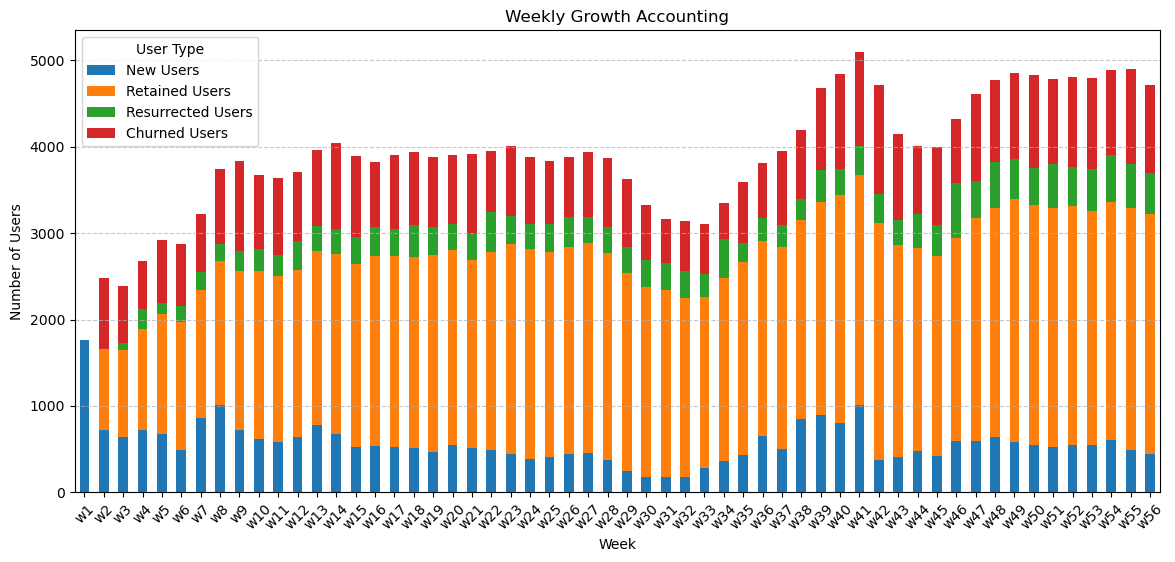

In [19]:
plt.figure(figsize=(12, 6))
growth_df.set_index("Week")[["New Users", "Retained Users", "Resurrected Users", "Churned Users"]].plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Weekly Growth Accounting")
plt.ylabel("Number of Users")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.legend(title="User Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Weekly Quick Ratio Trend: Monitoring Growth Performance

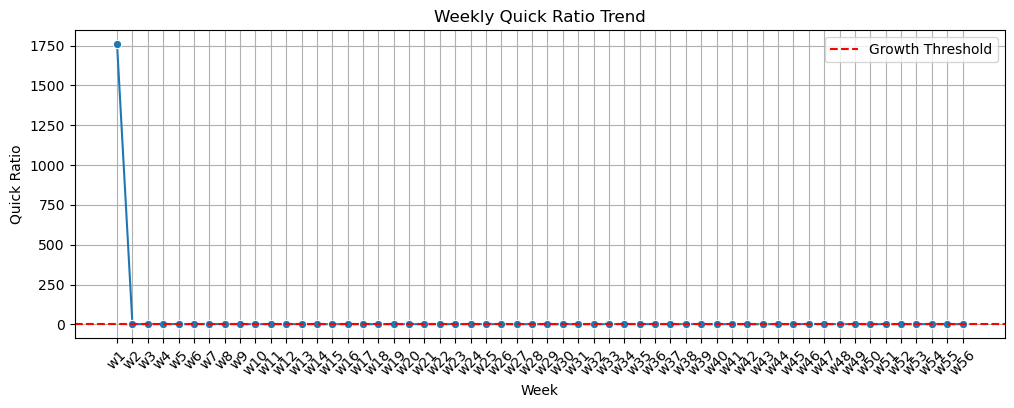

In [21]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=growth_df, x="Week", y="Quick Ratio", marker='o')
plt.axhline(y=1, color='r', linestyle='--', label="Growth Threshold")
plt.title("Weekly Quick Ratio Trend")
plt.ylabel("Quick Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

##### Removing the Outlier to get better understanding

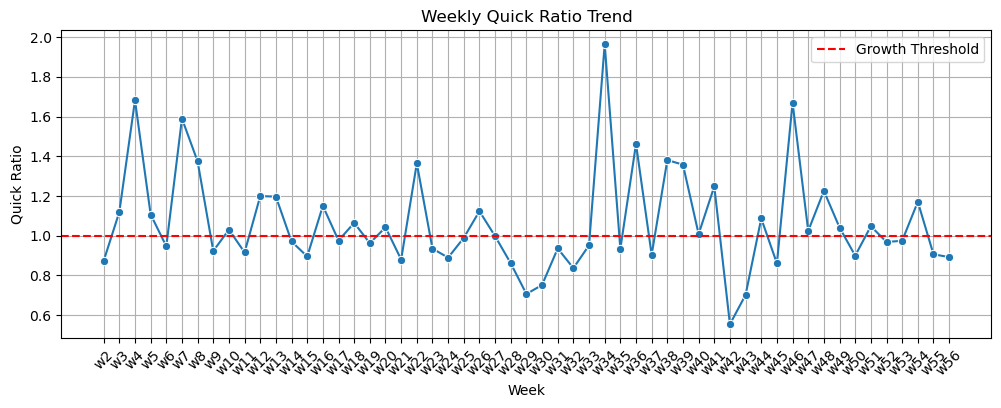

In [23]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=growth_df[growth_df["Quick Ratio"] < 10], x="Week", y="Quick Ratio", marker='o')  # Excluding extreme values
plt.axhline(y=1, color='r', linestyle='--', label="Growth Threshold")
plt.title("Weekly Quick Ratio Trend")
plt.ylabel("Quick Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

##### Keeping the Outlier but converting the scale in Log scale

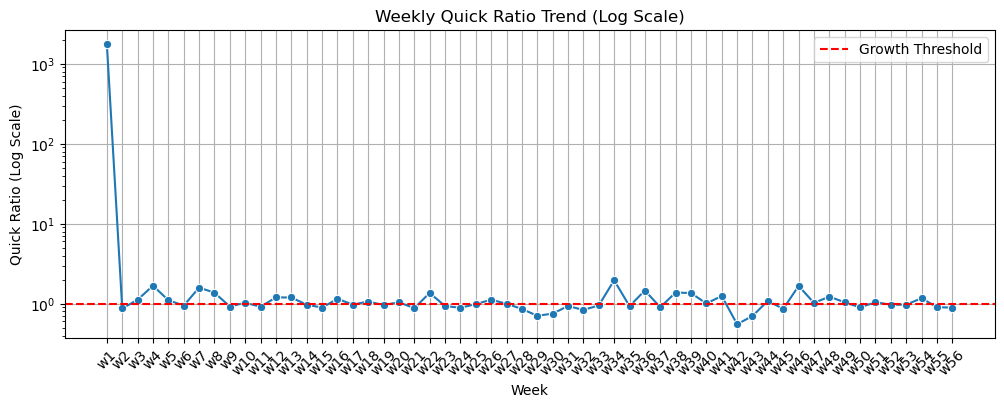

In [25]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=growth_df, x="Week", y="Quick Ratio", marker='o')
plt.axhline(y=1, color='r', linestyle='--', label="Growth Threshold")
plt.yscale("log")  # Log scale to handle large variations
plt.title("Weekly Quick Ratio Trend (Log Scale)")
plt.ylabel("Quick Ratio (Log Scale)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

##### Retention and Churn Rate Trend: Analyzing User Engagement and Loss

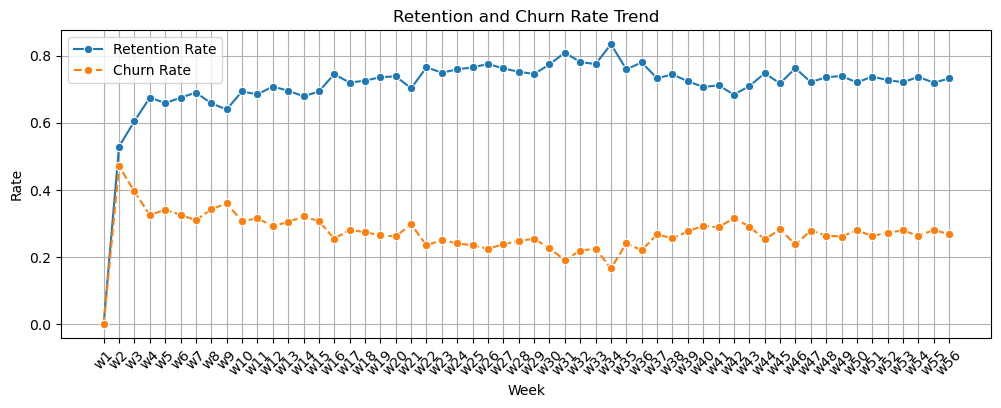

In [27]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=growth_df, x="Week", y="Retention Rate", marker='o', label="Retention Rate")
sns.lineplot(data=growth_df, x="Week", y="Churn Rate", marker='o', label="Churn Rate", linestyle='--')
plt.title("Retention and Churn Rate Trend")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

##### Growth Accounting Summary

In [49]:
print(growth_df.describe())


         New Users  Retained Users  Resurrected Users  Churned Users  \
count    56.000000       56.000000          56.000000      56.000000   
mean    568.285714     2186.910714         322.964286     825.250000   
std     245.028734      532.480517         122.716816     202.530738   
min     175.000000        0.000000           0.000000       0.000000   
25%     437.000000     2058.500000         268.000000     720.000000   
50%     532.000000     2284.500000         309.500000     823.500000   
75%     647.500000     2449.000000         379.500000     984.500000   
max    1759.000000     2825.000000         634.000000    1269.000000   

       Quick Ratio  Retention Rate  Churn Rate  Computed WAU  Reported WAU  \
count    56.000000       56.000000   56.000000     56.000000           0.0   
mean     32.455688        0.710015    0.272128   3078.160714           NaN   
std     234.914225        0.108133    0.061083    557.533555           NaN   
min       0.553980        0.000000    0

##### Key Insights

In [54]:

if growth_df["Quick Ratio"].mean() > 1:
    print("✅ The business is growing as the Quick Ratio is consistently above 1.")
else:
    print("⚠️ Growth is weak; the Quick Ratio is around or below 1, meaning churn offsets new user acquisition.")

if growth_df["Retention Rate"].mean() > 0.5:
    print("📈 Strong retention! Users are consistently coming back.")
else:
    print("📉 Retention is low; focusing on reducing churn is critical.")



✅ The business is growing as the Quick Ratio is consistently above 1.
📈 Strong retention! Users are consistently coming back.
